# Step 1: Network Filtering and Processing
---
### This the first of five steps to running BikewaySim
1. __Process network spatial data into a routable network graph format__
2. Reconcile networks into one through node and link overlap conflation
3. Create final network graph and calculate link costs
4. Create OD tables
5. Run BikewaySim

Run this code block by block to convert a road network shapefile in ESRI Shapefile, GeoJSON, or GeoPackage format into a routable and conflated network graph to use in BikewaySim.

Note that three networks were used in this project. While code to obtain OSM GeoJSONs has been included with osm_processing notebook, the ABM and HERE networks need to be sourced from the Atlanta Regional Commission and HERE respectively. You can run most of this code with only OSM data, but you can skip Step 2.

## Import/install the following packages:

In [1]:
import os
from pathlib import Path
import time
import geopandas as gpd
import pickle

## Import Network Filter Module:

In [2]:
from network_filter import *

## Set Directory:
Modify this directory to where you stored your network shapefiles.

In [3]:
user_directory = os.fspath(Path.home()) #get home directory and convert to path string
file_directory = r"/Documents/BikewaySimData" #directory of bikewaysim outputs
os.chdir(user_directory+file_directory)

### Choose projected coordinate reference system (CRS)
This needs to be set to check that all the data is in the same CRS. The one used for this study was EPSG 2240 (https://spatialreference.org/ref/epsg/nad83-georgia-west-ftus/).

In [4]:
desired_crs = "EPSG:2240"

## Choose study area:
Specify what area you want to mask the network data by. Only network links that are partially or fully within the study area will be imported. Note: network links are NOT clipped (because this cuts off nodes).

The area of the marta study area is 887.78 square miles.


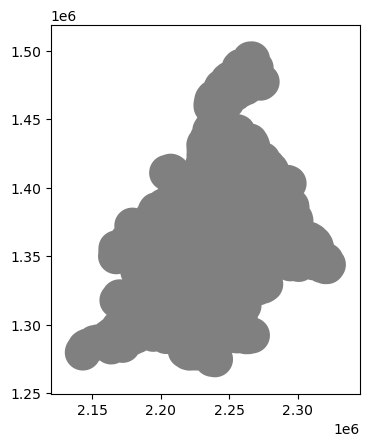

In [5]:

studyareafp = r'base_shapefiles/studyareas/marta.gpkg'
studyarea_name = 'marta'

#other filepaths
#studyareafp = r'base_shapefiles/studyareas/atl_district5.gpkg'
#studyarea_name = 'atl_district5'
#studyareafp = r'base_shapefiles/studyareas/ITS4US_StudyBoundary.shp'
#studyarea_name = 'its4us'
#studyareafp = r'base_shapefiles/studyareas/district5.geojson'
#studyarea_name = 'district5'
#studyareafp = r'base_shapefiles/bikewaysim_study_area/bikewaysim_study_area.shp'
#studyarea_name = 'bikewaysim'
#city_of_atlantafp = r'base_shapefiles/coa/Atlanta_City_Limits.shp'
#atlanta_regional_commissionfp = r'base_shapefiles/arc/arc_bounds.shp'

studyarea = import_study_area(studyareafp, studyarea_name, desired_crs)

## Network Mapper
This is how network node ID's will be identified and coded
- the first number in the node ID represents its origin network
- all numbers after that are the original network ID. we did this to make sure that there are no duplicate network ids and to make it easy to retreive the original network id.

In [6]:
network_mapper = {
    "abm": "1",
    "here": "2",
    "osm": "3",
    "original": "0",
    "created": "1"
}

## Network Data Filepaths:
Use this to specify the filepath of your network's links and/or nodes. Only links are required because nodes can be created from the links.

In [7]:
abmfp = r'base_shapefiles/arc/ABM2020-TIP20-2020-150kShapefiles-outputs.gdb'
abmnodesfp = r'base_shapefiles/arc/ABM2020-TIP20-2020-150kShapefiles-outputs.gdb'
herefp = r'base_shapefiles/here/Streets.shp'
osmfp = rf'base_shapefiles/osm/{studyarea_name}.gpkg'

If your network file has layers, you can use this code snippet to print them out:
```
import fiona
fiona.listlayers('base_shapefiles/arc/ABM2020-TIP20-2020-150kShapefiles-outputs.gdb')
```

## Set Network Import Settings
Creates a dictionary to specify inputs for the filter networks function. For new networks follow this format:

```python
network = {
       "studyarea": studyarea, #geodataframe of the study area
       "studyarea_name": studyarea_name, #name for the study area
       "networkfp": networkfp, #filepath for the network, specified earlier
       "network_name": 'abm', #name for the network being evaluated
       "network_mapper": network_mapper, #leave this, edit in the block above
       "layer": 0 #if network has layers, then specify which layer to look at; if no layers then leave as 0 
       "desired_crs": "desired_crs", # leave this, edit in the CRS block
       "nodesfp":None, # specify the nodes path if available, otherwise leave as None
       "node_id": None, # specify the column in the nodes file that has the node id information, if not available leave as 0
       "A": "A", #column with the starting node id; replace with None if there isn't a column
       "B": "B", #column with the ending node id; replace with None if there isn't a column
       "bbox": True, #use the bounding box of the study area as the mask for bringing in features instead of the polygon boundaries
       }
```

In [8]:
abm = {
       "studyarea": studyarea,
       "studyarea_name": studyarea_name,
       "networkfp": abmfp,
       "network_name": 'abm',
       "network_mapper": network_mapper,
       "layer": "DAILY_Link",
       "desired_crs": desired_crs,
       "nodesfp": abmnodesfp,
       "nodes_layer":"DAILY_Node",
       "node_id": 'N',
       "A": "A",
       "B": "B",
       "bbox":True
        }

In [9]:
here = {
       "studyarea": studyarea,
       "studyarea_name": studyarea_name,
       "networkfp": herefp,
       "network_name": 'here',
       "network_mapper": network_mapper,
       "layer":None,
       "desired_crs":desired_crs,
       "nodesfp":None,
       "nodes_layer":None,
       "node_id": None,
       "A": "REF_IN_ID",
       "B": "NREF_IN_ID",
       "bbox":True
       }

In [10]:
osm = {
      "studyarea": studyarea,
       "studyarea_name": studyarea_name,
       "networkfp": osmfp,
       "network_name": 'osm',
       "network_mapper": network_mapper,
       "layer":"links",
       "desired_crs":desired_crs,
       "nodesfp":osmfp,
       "nodes_layer":"nodes",
       "node_id": "osmid",
       "A": "A",
       "B": "B",
       "bbox":True
       }

## Run Network Filter Module to Create Initial Subnetworks
From the network_filter.py file run the filter networks function. This will first import the spatial data and then filter the data into a base, road, bike, or serivce link. 
**Note: If this is the a new network that is not OSM, HERE, or ABM then specify a new filter method by going into the network_filter.py file.** Otherwise, none of the links will be filtered into road/bike/service links. **Also note: all spatial files are being projected to EPSG 2240 right now.** Need to modify later.

### Filter ABM

In [23]:
filter_networks(**abm)

C:\Users\tpassmore6\Documents\GitHub\BikewaySimDev\network_filter.py:117: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  links = gpd.read_file(networkfp, mask = studyarea, layer = layer).explode().droplevel(level=1).to_crs(desired_crs)


Cleaning measures applied for abm...
No further filter needed for abm
No further filter needed for abm
No bike links present for abm
No service links present for abm
abm imported... took 4.06 minutes


### Filter HERE

In [24]:
filter_networks(**here)

C:\Users\tpassmore6\Documents\GitHub\BikewaySimDev\network_filter.py:114: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  links = gpd.read_file(networkfp, mask = studyarea).explode().droplevel(level=1).to_crs(desired_crs)
C:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


here road filter applied...
here road filter applied...
here bike filter applied...
here service filter applied...
here imported... took 25.75 minutes


### Filter OSM

In [11]:
filter_networks(**osm)

C:\Users\tpassmore6\Documents\GitHub\BikewaySimDev\network_filter.py:117: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  links = gpd.read_file(networkfp, mask = studyarea, layer = layer).explode().droplevel(level=1).to_crs(desired_crs)


Cleaning measures applied for osm...
osm roadbike filter applied...
osm road filter applied...
osm bike filter applied...
osm service filter applied...
osm imported... took 14.49 minutes


## Summurize filtered networks
#### Prints out:
- Number of nodes
- Number of links
- Total length of all links
- Average link length

#### Exports:
- CSV file with all the network statistics.

In [ ]:
from network_summary_stats import * 

#network names to look for, will search your directory for network name
networks = ["abm","here","osm"]

#summurize networks and export summary as "network_summary.csv in the working directory
sum_all_networks(networks, studyarea_name)

In [15]:
studyarea_name

'marta'